
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [105]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [4]:
# This cell allows full compatibility between execution in Google Colab and in local
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files

if IN_COLAB:
    uploaded = google.colab.files.upload()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = '/content/drive/MyDrive/ML/Data/FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [107]:
df0.describe(include = 'all')

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
count,5114.000000,5114,5114.000000,5114.000000,5114.000000,5114,5114,5114,5114.0,5114.000000,5114.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000
unique,NaN,4,NaN,NaN,NaN,2,12,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,April to June,NaN,NaN,NaN,Male,February,South East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1341,NaN,NaN,NaN,3050,445,736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.363707,NaN,1.841807,0.521901,519.898868,NaN,NaN,NaN,2014.0,679.542002,53.802698,10.475023,2.146960,25.727801,68.108342,19.635469,58.943391,7.072523,9.934257,2.508315
std,1.244704,NaN,0.743052,0.945622,411.543093,NaN,NaN,NaN,0.0,499.596175,16.187912,8.798118,2.034353,18.371345,57.347230,18.725096,44.751694,2.931651,5.485175,1.358023
min,1.000000,NaN,0.000000,0.000000,-246.916821,NaN,NaN,NaN,2014.0,0.000000,17.000000,0.086667,0.108333,0.060667,0.195000,0.000000,0.520000,0.357694,0.000000,0.159672
25%,1.000000,NaN,1.000000,0.000000,260.598783,NaN,NaN,NaN,2014.0,306.954000,41.000000,4.452500,0.866667,12.222167,29.141668,6.917083,27.148333,5.171614,5.979375,1.760525
50%,2.000000,NaN,2.000000,0.000000,426.977227,NaN,NaN,NaN,2014.0,548.086000,54.000000,8.374167,1.625000,22.245817,54.708336,13.736667,49.356667,6.575851,8.804690,2.254208
75%,3.000000,NaN,2.000000,1.000000,651.003763,NaN,NaN,NaN,2014.0,925.652500,67.000000,14.005333,2.816667,35.037167,90.480003,26.000000,78.281662,8.295746,12.520942,2.893561


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [108]:
null_row =  df0.shape[0] - df0.dropna().shape[0]
print(null_row)

1668


#### Drop rows with nulls

In [110]:
df1 = df0.dropna().copy()
print("After dropping rows with nulls the dataset has {} rows".format(df1.shape[0]))

After dropping rows with nulls the dataset has 3446 rows


##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [111]:
df1["SexHRP"] = df1["SexHRP"].apply(lambda x: 1 if x == "Male" else 0)
df1['qmeat_hhsize_ratio'] = df1['qmeat']/df1['hhsize']
df1['income_hhsize_ratio'] = df1['income']/df1['hhsize']

##### Use only the columns that the experts consider interesting
This is suggested by background information

In [112]:
df = df1[['adults_n','children_n', 'SexHRP',	'AgeHRP',	'qmeat_hhsize_ratio',	'income_hhsize_ratio',	'uvmeat']]
df.head()

,adults_n,children_n,SexHRP,AgeHRP,qmeat_hhsize_ratio,income_hhsize_ratio,uvmeat
1,2,2,1,38,1.511250,206.130000,8.813621
2,2,0,1,54,5.890083,135.962500,7.965790
4,3,0,1,64,4.285667,165.346667,5.726323
5,2,2,1,70,8.968250,66.632500,8.451528
7,3,0,1,64,4.079111,134.393333,5.904745


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [113]:
target = "qmeat_hhsize_ratio"
X = df.drop(target,axis=1)
y = df[target]

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [114]:
ncols=3
import math
nrows = math.ceil((df.shape[1]-1)/ncols)
figwidth = ncols * 7
figheigth = nrows*5

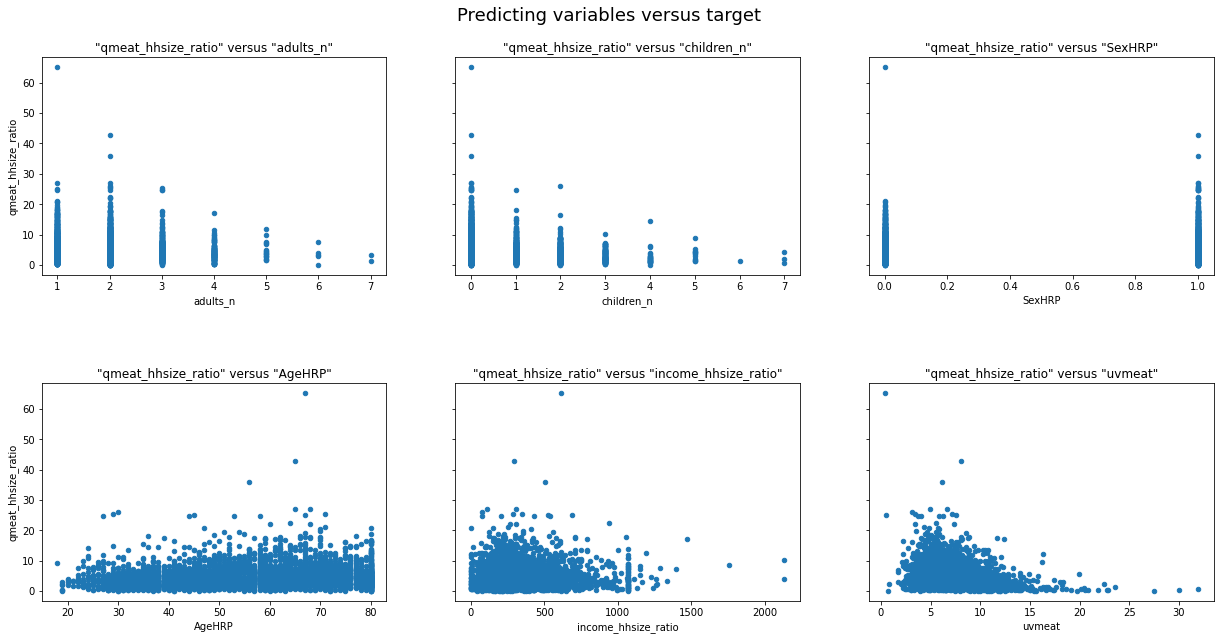

In [115]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figwidth, figheigth),sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Predicting variables versus target", fontsize=18, y=0.95)

for c, ax in zip(df.drop(target,axis=1).columns,axs.ravel()):
    df.sort_values(by=c).plot.scatter(x=c,y=target
                                    , title = '"{}" versus "{}"'.format(target,c)
                                    , ax=ax)

### Show the *_p-values_* of the target with respect to the variables

In [116]:
from sklearn.feature_selection import f_regression
_, p_values = f_regression(X,y)
p_values_show = pd.DataFrame({'Variable': X.columns, 'p-value': p_values})
p_values_show

,Variable,p-value
0,adults_n,1.415945e-05
1,children_n,1.077386e-30
2,SexHRP,8.429827e-02
3,AgeHRP,1.710126e-21
4,income_hhsize_ratio,1.211099e-03
5,uvmeat,4.789746e-52


## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [117]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = random_state, train_size= 0.7)
print("Training set and test set have {} and {} elements respectively".format(Xtrain.shape[0], Xtest.shape[0]))

Training set and test set have 2412 and 1034 elements respectively


### Consider a reduced dataset containing the chosen variable and the target
### First experiment: Univariate regression qmeat_hhsize_ratio as a linear function of adults_n

In [118]:
pred = 'adults_n'
Xtrain_r = Xtrain[pred].values.reshape(-1,1) # transform a series into a one-column array
Xtest_r = Xtest[pred].values.reshape(-1,1)

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [119]:
model = linear_model.LinearRegression()
model.fit(Xtrain_r, ytrain)
ytrain_model = model.predict(Xtrain_r)
ytest_model = model.predict(Xtest_r)

#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [120]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def f_test(y_true, y_pred, n_var, n_obs, sn=.95):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var + 1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFT = n - 1
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE 
    MST = SST / DFT
    F = MSM / MSE
    p = 1 - scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic 
    return F, p

#### Compute the statistical significance of the model

In [121]:
#perform F-test
f_statistic_uni, p_value_uni = f_test(ytrain, ytrain_model
                                    , Xtrain_r.shape[1], Xtrain_r.shape[0])

# The coefficient
coeff_uni = model.coef_[0] # the coefficient is returned as a one-element list
intercept_uni = model.intercept_
# The root mean squared error
rmse_uni = mean_squared_error(ytest, ytest_model, squared=False)
# Coefficient of determination = 1 is perfect prediction
r2_uni = r2_score(ytest, ytest_model)

# The results are assembled in a dataframe for a compact view
pd.DataFrame({'Univariate Linear - Value' : [intercept_uni
                        , coeff_uni
                        , rmse_uni
                        , r2_uni
                        , f_statistic_uni
                        , p_value_uni]}
            , index = ['Intercept for "{}"'.format(pred)
                     , 'Coefficient for "{}"'.format(pred)
                     , 'rmse'
                     , 'r2'
                     , 'f-statistic'
                     , 'p-value'])

,Univariate Linear - Value
"Intercept for ""adults_n""",5.646984
"Coefficient for ""adults_n""",-0.326893
rmse,3.886323
r2,0.007595
f-statistic,9.841162
p-value,0.001727


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [122]:
model_multi = linear_model.LinearRegression()
model_multi.fit(Xtrain, ytrain)
ytrain_model_multi = model_multi.predict(Xtrain)
ytest_model_multi = model_multi.predict(Xtest)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [123]:
pd.DataFrame({'Variable': X.columns, 'Coefficient': model_multi.coef_})

,Variable,Coefficient
0,adults_n,-0.318682
1,children_n,-0.650924
2,SexHRP,0.383162
3,AgeHRP,0.014913
4,income_hhsize_ratio,0.000989
5,uvmeat,-0.392620


#### Compute the statistical significance

In [124]:
_, p_values = f_regression(Xtrain, ytrain_model_multi)
p_values_show = pd.DataFrame({'Variable': X.columns, 'p-value': p_values})
p_values_show

,Variable,p-value
0,adults_n,4.812836e-19
1,children_n,1.384315e-188
2,SexHRP,5.806116e-10
3,AgeHRP,3.199609e-119
4,income_hhsize_ratio,6.460728e-08
5,uvmeat,0.000000e+00


#### Compute the quality measures

In [125]:
#perform F-test
f_statistic_multi, p_value_multi = f_test(ytrain, ytrain_model_multi
                                        , Xtrain.shape[1], Xtrain.shape[0])
                                        
# The mean squared error
rmse_multi = mean_squared_error(ytest, ytest_model_multi, squared=False)
# print("The MSE for the multivariate linear regression of '{}' is: {:8.2f}"\
#     .format(target, rmse_dt))
# Coefficient of determination=1 is perfect prediction
r2_multi = r2_score(ytest, ytest_model_multi)
# print("The 'R square' for the multivariate linear regression of '{}' is: {:8.2f}"\
#     .format(target, r2_dt))
pd.DataFrame({'Multivariate Linear - Value' : [rmse_multi
                        , r2_multi]}
            , index = ['rmse'
                     , 'r2'])
# The results are assembled in a dataframe for a compact view
pd.DataFrame({'Univariate Linear - Value' : [rmse_multi
                        , r2_multi
                        , f_statistic_multi
                        , p_value_multi]}
            , index = ['rmse'
                     , 'r2'
                     , 'f-statistic'
                     , 'p-value']).style.format(precision=4)

,Univariate Linear - Value
rmse,3.6651
r2,0.1173
f-statistic,57.4179
p-value,0.0000


## Decision Tree Multivariate Regresson

In [126]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [127]:
model_tree = DecisionTreeRegressor(random_state = random_state)
model_tree.fit(Xtrain, ytrain)
ytrain_tree = model_tree.predict(Xtrain)
fitted_max_depth = model_tree.tree_.max_depth
print("The maximum depth of the full Decision Tree Regressor is ", fitted_max_depth)

The maximum depth of the full Decision Tree Regressor is  34


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [128]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': list(range(1,fitted_max_depth))}
# create the grid search cross validation object
dt_gscv = GridSearchCV(estimator=DecisionTreeRegressor(random_state=random_state)
                    , param_grid=param_grid
                    , scoring='neg_mean_squared_error' # select model with minimum mse
                    )
dt_gscv.fit(Xtrain,ytrain);
dt_best = dt_gscv.best_estimator_ # the GridSearchCV returns the best estimator
best_max_depth = dt_best.tree_.max_depth
print("The optimal maximum depth for the decision tree is {}".format(best_max_depth))

The optimal maximum depth for the decision tree is 2


In [129]:
ytest_best_model = dt_best.predict(Xtest)
rmse_dt = mean_squared_error(ytest, ytest_best_model, squared = False)
print("Decision Tree Regression - RMSE = {:.2f}".format(rmse_dt))

Decision Tree Regression - RMSE = 3.79


#### Show the tree

[Text(0.5, 0.8333333333333334, 'uvmeat <= 7.393\nsquared_error = 14.32\nsamples = 100.0%\nvalue = 5.015'),
 Text(0.25, 0.5, 'children_n <= 0.5\nsquared_error = 15.448\nsamples = 62.5%\nvalue = 5.68'),
 Text(0.125, 0.16666666666666666, 'squared_error = 17.078\nsamples = 43.4%\nvalue = 6.281'),
 Text(0.375, 0.16666666666666666, 'squared_error = 9.044\nsamples = 19.1%\nvalue = 4.313'),
 Text(0.75, 0.5, 'uvmeat <= 12.428\nsquared_error = 10.476\nsamples = 37.5%\nvalue = 3.906'),
 Text(0.625, 0.16666666666666666, 'squared_error = 10.833\nsamples = 33.0%\nvalue = 4.197'),
 Text(0.875, 0.16666666666666666, 'squared_error = 2.744\nsamples = 4.5%\nvalue = 1.784')]

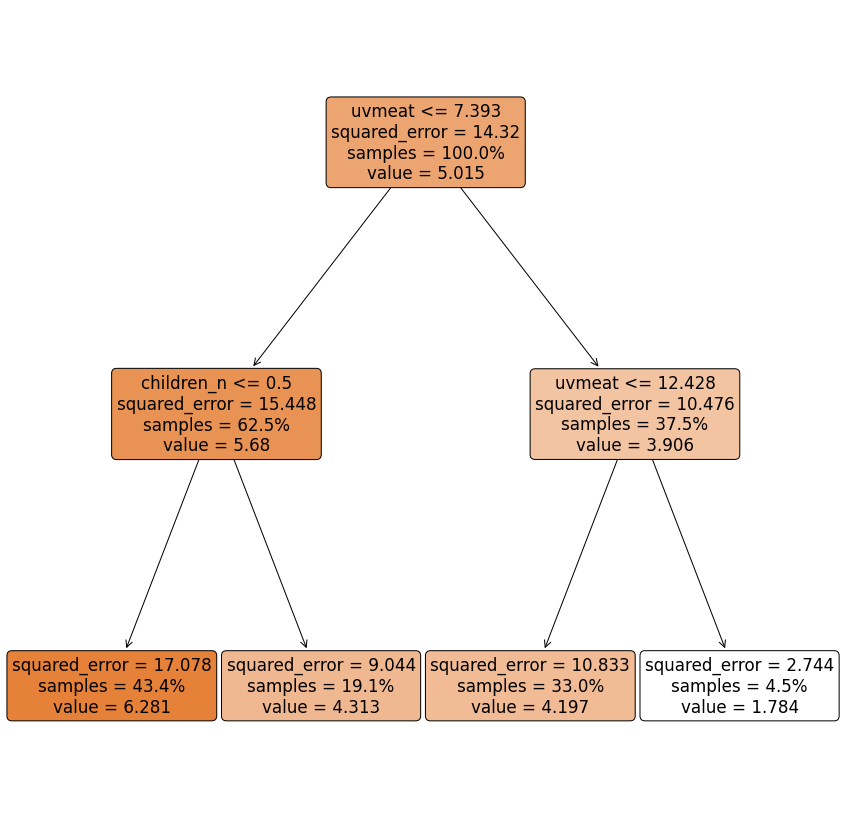

In [131]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
figure(figsize = (15,15))
plot_tree(dt_best,
          filled = True,
          feature_names = ['adults_n','children_n', 'SexHRP',	'AgeHRP',	'income_hhsize_ratio',	'uvmeat'],
          rounded = True,
          proportion = True,
          )

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

In [134]:
from sklearn.ensemble import RandomForestRegressor
clf = GridSearchCV(estimator = RandomForestRegressor(random_state=random_state)
                    , param_grid=param_grid
                    , scoring='neg_mean_squared_error' # select model with minimum mse
                    )
clf.fit(Xtrain,ytrain);


In [135]:
forest_best = clf.best_estimator_
best_forest_depth = forest_best.max_depth
print("The optimal maximum depth for the decision tree is {}".format(best_forest_depth))

The optimal maximum depth for the decision tree is 4


In [137]:
ytest_best_forest = forest_best.predict(Xtest)
rmse_dt = mean_squared_error(ytest, ytest_best_forest, squared = False)
print("Decision Tree Regression - RMSE = {:.2f}".format(rmse_dt))

Decision Tree Regression - RMSE = 3.58


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results